### 1. Reading data
This script uses [Middlebury Computer Vision dataset](http://vision.middlebury.edu/mview/data/) with a render of "Temple of the Dioskouroi" in Agrigento, Sicily.  
It contains 312 views sampled on a hemisphere. There are also files with camera parameters and angles for each image.

In [1]:
import os

dataset_dir  = "data/temple/"
images_count = len([i for i in os.listdir(dataset_dir) if i.endswith(".png")])
print(f"Found {images_count} images in {dataset_dir} dataset.")

Found 312 images in data/temple/ dataset.


In [2]:
import cv2
frame1 = cv2.imread(os.path.join(dataset_dir, "temple{:04d}.png".format(1)))
frame2 = cv2.imread(os.path.join(dataset_dir, "temple{:04d}.png".format(2)))
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

### 2. Feature extraction
Extracting features from both images using ORB (oriented BRIEF) keypoint detector and descriptor extractor.

In [6]:
extractorORB = cv2.ORB_create()
keypoints1, descr1 = extractorORB.detectAndCompute(frame1, mask=None)
keypoints2, descr2 = extractorORB.detectAndCompute(frame2, mask=None)

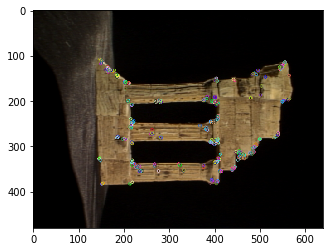

In [7]:
import matplotlib.pyplot as plt
keypointsImage = cv2.drawKeypoints(frame1, keypoints1, None)
plt.imshow(keypointsImage)
plt.show()